In [1]:
import tarfile,sys
import pandas as pd
import os
import simplejson
import re as regex
import time
import json
from random import random
from textblob import TextBlob
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime, date, time, timedelta
from dateutil import parser as dateparser
from collections import Counter

In [2]:
parent_dir = 'shared_task_data/'
train_dir = 'final_training_data/'
test_dir = 'final_testing_data/'

In [19]:
def untar(fname, extract_path):
    if (fname.endswith("tar") or fname.endswith("tgz") ):
        tar = tarfile.open(fname)
        tar.extractall(extract_path)
        tar.close()
        print("Extracted " + str(fname) + " in Current Directory")
    else:
        print("Not a tar.gz file: '%s '" % sys.argv[0])

In [20]:
# untar parent directory, training and testing subdirectories
untar('shared_task_data.tar', parent_dir)

Extracted shared_task_data.tar in Current Directory


In [22]:
for i in range(1, 51): 
    fpath=parent_dir + train_dir + str(i) + '.tgz'
    untar(fpath, train_dir)
    
for i in range(60, 90): 
    fpath=parent_dir + test_dir + str(i) + '.tgz'
    untar(fpath, test_dir)

Extracted shared_task_data/final_training_data/1.tgz in Current Directory
Extracted shared_task_data/final_training_data/2.tgz in Current Directory
Extracted shared_task_data/final_training_data/3.tgz in Current Directory
Extracted shared_task_data/final_training_data/4.tgz in Current Directory
Extracted shared_task_data/final_training_data/5.tgz in Current Directory
Extracted shared_task_data/final_training_data/6.tgz in Current Directory
Extracted shared_task_data/final_training_data/7.tgz in Current Directory
Extracted shared_task_data/final_training_data/8.tgz in Current Directory
Extracted shared_task_data/final_training_data/9.tgz in Current Directory
Extracted shared_task_data/final_training_data/10.tgz in Current Directory
Extracted shared_task_data/final_training_data/11.tgz in Current Directory
Extracted shared_task_data/final_training_data/12.tgz in Current Directory
Extracted shared_task_data/final_training_data/13.tgz in Current Directory
Extracted shared_task_data/final_t

## Preprocessing

In [3]:
from sklearn import preprocessing as pp
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from tokenize import generate_tokens
import numpy as np
import re

def preprocess_tweet(tweet):
    stemmer = PorterStemmer()
    # convert all strings to lowercase
    tweet = tweet.lower()
    # remove all punctuations  
    tweet = re.sub('[^\w\s]', '', tweet)
    words = tweet.split()
    _words = [] # final word list

    for index, word in enumerate(words):
        # remove all stopwords
        if word not in stopwords.words('english'):
            # remove stemming 
            #_words.append(stemmer.stem(word)) 
            _words.append(word)

    tweet = ' '.join(_words)
    return tweet 

## Define Features

In [4]:
def insomnia_count(target, pos_count, neg_count):
    hour = target['created_at'].hour
    # positive count for tweets from 9pm - 6am
    if hour > 6 and hour < 21:
        neg_count += 1
    else:
        pos_count += 1
    return pos_count, neg_count

def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return sentiment


def avg_sentiment(statuses):
    avg = 0
    for status in statuses:
        blob = TextBlob(status)
        sentiment = blob.sentiment.polarity
        avg += sentiment
    avg_sentiment = avg / len(statuses)
    return avg_sentiment

def first_person(statuses):
    count = 0
    first_person = ["i", "id", "ill", "im", "ive", "me", "my"]
    for status in statuses:
        text = status.split()
        for word in first_person:
            count += text.count(word)   
    return count / len(statuses)

def absolutist_terms(statuses):
    absolutist_terms = ["absolutely", "all", "always", "complete", "completely", "constant", "constantly", "definitely", "entire", "ever", "every", "everyone", "everything", "full", "must", "never", "nothing", "totally", "whole"]
    count = 0
    for status in statuses:
        for term in absolutist_terms:
            count += status.count(term)
    return count / len(statuses)

def tsugawa_terms(statuses):
    tsugawa_terms = ["even if", "low fever", "very", "workplace", "hopeless", "disappear", "too much", "sickness", "bad", "hospital", "anxiety", "severe", "suicidal", "nausea", "drowsiness", "fatigue", "nervousness", "addictive", "attacks", "episodes", "sleep", "tolerance", "cope", "care"]
    count = 0
    count_per_tweet = 0
    for status in statuses:
        for term in tsugawa_terms:
            count += status.count(term)
    return count / len(statuses)

def retweet_count(target, retweet_count):
    retweet_count += int(target['retweet_count'])
    return retweet_count

def url_count(target, url_count):
    url_count += len(target['entities']['urls'])
    return url_count

def num_word_char(statuses):
    num_char = 0
    num_words = 0
    for status in statuses:
        num_words += len(status.split())
        num_char += len(status)
    
    num_words = num_words / len(statuses)
    num_char = num_char / len(statuses)
    return num_words, num_char

def usertags(target, usertags, set_usertags):
    user_mentions = target['entities']['user_mentions']
    for user in user_mentions:
        set_usertags.add(user['screen_name'])

    usertags += len(user_mentions)
    return usertags, set_usertags

## Read User Tweets

In [5]:
# read user csv file and filter for only depression and control
userInfo = pd.read_csv('anonymized_user_info_by_chunk.csv')
user_condition = {}
for index, row in userInfo.iterrows():
    userName = row['anonymized_screen_name']
    condition = row['condition'] 
    if condition == 'depression':
        user_condition[userName] = 1
    elif condition == 'control':
        user_condition[userName] = 0

## Sentiment Analysis 

In [6]:
# get most positive and negative words by users
columns = ['user', 'depression', 'positive_tweets', 'negative_tweets', 'negative_tweet_rate', 'positive_tweet_rate']
train_data=pd.DataFrame(columns=columns)
test_data=pd.DataFrame(columns=columns)

#read user tweets
for user, condition in user_condition.items():
    test = False
    tweet_train_file = train_dir + user + '.tweets'
    tweet_test_file = test_dir + user + '.tweets'
    if os.path.isfile(tweet_train_file):
        tweet_file = tweet_train_file 
    elif os.path.isfile(tweet_test_file):
        tweet_file = tweet_test_file
        test = True
    else:
        print('no tweets found for user')
        continue
    
    try:  
        print('Reading file '+ tweet_file)
        tweets = pd.read_json(tweet_file, lines=True)
        tweets['user'] = user
        tweets['depression'] = condition
        neg_tweets = []
        pos_tweets = []
        for i in range(len(tweets)):
            tweet = tweets.iloc[i]
            # preprocess tweet texts per user 
            text = preprocess_tweet(tweet['text'])
            # add extremely negative and positive tweets
            polarity = get_sentiment(text)
            if polarity < -0.7:
                neg_tweets.append(text)
            elif polarity > 0.7:
                pos_tweets.append(text)
        tweets['positive_tweets'] = ' '.join(pos_tweets)
        tweets['negative_tweets'] = ' '.join(neg_tweets)
        tweets['negative_tweet_rate'] = len(neg_tweets)/len(tweets)    
        tweets['positive_tweet_rate'] = len(pos_tweets)/len(tweets)    
                
        user_row = tweets[columns].loc[0:0]
        if test == True:
            test_data = test_data.append(user_row)
        else:
            train_data = train_data.append(user_row)
    except:
        print("Error parsing tweet!")

no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_training_data/p1oWIeRy95.tweets
Reading file final_training_data/u6Q1cPYaegBS.tweets
Reading file final_training_data/q5nbV1Dwkx3Uz8y.tweets
Error parsing tweet!
Reading file final_training_data/cpZb1zL.tweets
Reading file final_training_data/nC8trwq.tweet

Reading file final_training_data/fS_NsCmikG.tweets
Reading file final_training_data/r_AL08Us8KD.tweets
Reading file final_training_data/epbVjo65LYSb.tweets
Reading file final_training_data/fjLCf4wIe1Yts.tweets
Reading file final_training_data/hMuEjR7TAHw.tweets
Reading file final_training_data/l02NBMxaBtp.tweets
Reading file final_training_data/xR7COyw1hCgMdJ.tweets
Reading file final_training_data/fPnJmwvigb4NDB.tweets
Error parsing tweet!
Reading file final_training_data/c6RBMyzEGz.tweets
Reading file final_training_data/lNkP1wbG_.tweets
Reading file final_training_data/tYbkBjKn_HhbKA.tweets
Reading file final_training_data/tFm_Zt17.tweets
Reading file final_training_data/hWx1ZCISapk.tweets
Reading file final_training_data/f1gToeZMsown.tweets
Reading file final_training_data/lvXWGVOeVbaO.tweets
Error parsing tweet!
Reading file final_training_data/ndt26Jc2.tweets
Reading file final_training_data/tjUQM0XFoFd6.tweets
Reading file final_training_data/pKiT8RjFUoFNN.tweets
Reading file fi

Reading file final_training_data/d5W9F315ClWuT.tweets
Reading file final_training_data/xbm01RF4kr.tweets
Reading file final_training_data/u9k5tz3yeg38Z.tweets
Reading file final_training_data/quD3WcPmeNf9Ver.tweets
Reading file final_training_data/b7JDj_Sb.tweets
Reading file final_training_data/mrBNd41K.tweets
Reading file final_training_data/mFt6W0RyBGub.tweets
Reading file final_training_data/q0W_J_Ee.tweets
Reading file final_training_data/fPh49Tvz_Cu0y0R.tweets
Reading file final_training_data/vmXfij.tweets
Reading file final_training_data/pFRUDVnfMvng.tweets
Reading file final_training_data/ijinLoqohOP.tweets
Error parsing tweet!
Reading file final_training_data/oFnukUt21FYo.tweets
Reading file final_training_data/w9rpyg0EUSU03g.tweets
Reading file final_training_data/no6eldDW_U0Pq_.tweets
Reading file final_training_data/zvnSahMKTd.tweets
Reading file final_training_data/eTB92A2U3X5.tweets
Reading file final_training_data/wi3bUI3nYk_Pd.tweets
Reading file final_training_data/wWd

Reading file final_training_data/fdvbKeh4NIZ.tweets
Reading file final_training_data/hANUdm_kJzGbnl.tweets
Reading file final_training_data/uiHBxWiuleJL.tweets
Reading file final_training_data/bBj3tEy.tweets
Reading file final_training_data/sY0azlpwRe.tweets
Reading file final_training_data/xosKMdKMJ.tweets
Reading file final_training_data/cmvxX_NWJd5DL.tweets
Reading file final_training_data/gAxzxIWjvahh.tweets
Reading file final_training_data/xnozWTA40p.tweets
Reading file final_training_data/fvFcDA0P8oJ_6.tweets
Reading file final_training_data/dJJPhbPju.tweets
Reading file final_training_data/p2HB96F23s.tweets
Error parsing tweet!
Reading file final_training_data/rPubIuIf.tweets
Reading file final_training_data/guU7PUipk5n4.tweets
Reading file final_training_data/f2fooSn.tweets
Reading file final_training_data/cS8tppTDL3.tweets
Reading file final_training_data/bi0xOvA88H1OT.tweets
Error parsing tweet!
Reading file final_training_data/j11yDOcjhW.tweets
Reading file final_training_da

Reading file final_training_data/tkkzidBh9ZWsG.tweets
Error parsing tweet!
Reading file final_training_data/u4Nz74q5SCdyObn.tweets
Reading file final_training_data/k6aDpyIS0.tweets
Reading file final_training_data/t91wktiYrsF.tweets
Reading file final_training_data/e3OjnFN0VbsoV.tweets
Reading file final_training_data/ms_0SI9_YGA2B.tweets
Reading file final_training_data/qodUBoXFyHq6T03.tweets
Error parsing tweet!
Reading file final_training_data/snMj6XzZvN.tweets
Reading file final_training_data/k7F4IlnB5.tweets
Reading file final_training_data/oxkZfV_7pE.tweets
Reading file final_training_data/oetczv3_S3oPac.tweets
Error parsing tweet!
Reading file final_training_data/dadlS4XUHbvfHi.tweets
Error parsing tweet!
Reading file final_training_data/fNlTErjbA.tweets
Reading file final_training_data/ukNquMkP3W1.tweets
Reading file final_training_data/L844xvCOIjDJ3ot.tweets
Reading file final_training_data/n4BOlCvNErp75.tweets
Reading file final_training_data/dVulYpSpRz.tweets
Reading file fi

Reading file final_training_data/f8D2Tt5ySDU.tweets
Reading file final_training_data/pYZlibq.tweets
Reading file final_training_data/iTe8_RfG8.tweets
Reading file final_training_data/gxssg5e.tweets
Reading file final_training_data/b90Xd3CWW.tweets
Reading file final_training_data/c5egAWoKy8.tweets
Reading file final_training_data/jGC0j9ijNBn1.tweets
Reading file final_training_data/fONxVasny2.tweets
Reading file final_training_data/wmwQ6RjBaiq.tweets
Reading file final_training_data/nVHGUx.tweets
Reading file final_training_data/sObIxboD1JgpBHe.tweets
Reading file final_training_data/n8bDYXAG5S85.tweets
Reading file final_training_data/vpcHddZiD.tweets
Reading file final_training_data/mOanz1kg6b0oSxG.tweets
Reading file final_training_data/QIbT5IkcWpj.tweets
Reading file final_training_data/c1IQ5GCb_99LSxX.tweets
Error parsing tweet!
Reading file final_training_data/id4O8tg.tweets
Reading file final_training_data/sZVVktDN8qqjA.tweets
Reading file final_training_data/hbwm5Tyt801.tweets


no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/sgh85pBVTrOI5.tweets
Error parsing tweet!
Reading file final_testing_data/j15O_iq22wviI.tweets
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/LSdFmgw.tweets
Reading file final_testing_data/OHrn8EBpdMbPc.tweets
Error parsing tweet!
Reading file final_testing_data/oJBU65HkIKJ.tweets
Error parsing tweet!
Reading file final_testing_data/qUi02Rtnn9.tweets
Reading file final_testing_data/qz15FDkWR.tweets
Reading file final_testing_data/qdUlpt7G_xuDJ.tweets
Reading file final_testing_data/5trLyO.tweets
Reading file final_testing_data/xamatEwJzmBM.tweets
Reading file final_testing_data/dztLiT.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/pjmeJFCj9.tweets
Reading file final_testing_data/pLwkcIQ1KPKKNLE.tweets
Error parsing tweet!
Reading f

Reading file final_testing_data/vw1G3Kfi1K.tweets
Reading file final_testing_data/ede9eCGcC.tweets
Reading file final_testing_data/ngEVlO5dC.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/uAYNfjer5H4.tweets
Error parsing tweet!
Reading file final_testing_data/ohKTsoykPhh8ZuS.tweets
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/hOnaPe9X9ZuuoN.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/cJJldnDL5oP_QD.tweets
Error parsing tweet!
Reading file final_testing_data/dl7Vaigu.tweets
Reading file final_testing_data/ubNzj1B.tweets
Error parsing tweet!
Reading file final_testing_data/ngl7M2ou5B.tweets
Reading file final_testing_data/uwcXjnBq.tweets
Reading file final_testing_data/sopdPKAFkw3QerH.tweets
Reading file final_testing_data/u_P3xdlRS8naqbi.tweets
Reading file final_tes

no tweets found for user
no tweets found for user
Reading file final_testing_data/lYU6yETIaN3H.tweets
Reading file final_testing_data/cEkZxh6OEtC2.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/nYpuu7dWvXMFUG9.tweets
Reading file final_testing_data/rSaU1hkUY.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/puTtjUFpRciDHX.tweets
Reading file final_testing_data/gGRekzUp_6oLZ2P.tweets
Reading file final_testing_data/ljsDD9z1vYpW.tweets
no tweets found for user
Reading file final_testing_data/dn8Oyr4n.tweets
Reading file final_testing_data/vcR68dcu1de.tweets
Reading file final_testing_data/h8z2xMU8q7mMWY.tweets
Reading file final_testing_data/v8tLj9e.tweets
Reading file final_testing_data/q5tE5dA6xiDnQ.tweets
Error parsing tweet!
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/wo5BVq1NFaqo08.tweets
Reading file final_testing_data/p43muIH.tweets
Readin

Reading file final_testing_data/uF76QlQxlcOYn.tweets
Reading file final_testing_data/d8sMxxX8uhYioVo.tweets
Reading file final_testing_data/vvyhD9dsqxT.tweets
Reading file final_testing_data/bjc2Kgay.tweets
Reading file final_testing_data/f2gRmoHUul.tweets
Reading file final_testing_data/le__3ezwpf.tweets
Reading file final_testing_data/fyl6PKTMEeaweMw.tweets
Error parsing tweet!
Reading file final_testing_data/jKXYTGn9CNGOtK.tweets
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/ll_gyBvD2vo9A.tweets
Reading file final_testing_data/eVVQgZHpk9.tweets
Reading file final_testing_data/xMZSqgcL0pH.tweets
Error parsing tweet!
Reading file final_testing_data/si_wpIUDCDtRMtp.tweets
Reading file final_testing_data/iuqR1sQB9srL.tweets
no tweets found for user
Reading file final_testing_data/lCwkSx2Fau.tweets
Reading file final_testing_data/sqOFbJ0CQYM.tweets
Reading file final_testing_data/wuwHUfST.tweets
no twee

In [7]:
# save user data to file
test_data.to_csv('test_sentiment.csv', encoding='utf-8')
train_data.to_csv('train_sentiment.csv', encoding='utf-8')

### Build dictionary of depressed and positive words

In [13]:
train_data = pd.read_csv('train_sentiment.csv')
test_data = pd.read_csv('test_sentiment.csv')

depressed_dict = {} 
positive_dict = {} 
for index, row in train_data.iterrows():
    if row['depression'] == 1:
        neg_tweets = row['negative_tweets'] 
        if not isinstance(neg_tweets, str):
            continue
        for word in neg_tweets.split(' '):
            depressed_dict[word] = depressed_dict.get(word, 0) + 1
    else:
        if not isinstance(pos_tweets, str):
            continue
        pos_tweets = row['positive_tweets'] 
        for word in pos_tweets.split(' '):
            positive_dict[word] = positive_dict.get(word, 0) + 1
            

### Build Bag of Words based on top depressed and positive words

In [16]:
def build_bag_of_words(word_dict, data):
    text_feat = []
    unique_words = []
    labels = []
    # include words with counts > 10
    unique_words = [k for k,v in word_dict.items() if v > 50] # change to 50 with large dataset

    # for each user, create a feature vector with ith index as the count of ith word in the word list
    for index, row in data.iterrows():
        label = row['depression']
        tweets = row['negative_tweets'] 
        if not isinstance(tweets, str):
            continue

        feat = [0] * len(unique_words) 
        for word in tweets.split(' '):
            if word in unique_words:
                feat[unique_words.index(word)] += 1
        text_feat.append(feat)
        labels.append(label)

    return np.array(text_feat), labels

# build bag of words 
X_train, y_train = build_bag_of_words(depressed_dict, train_data)
X_train = pp.normalize(X_train, norm='l2')

X_test, y_test = build_bag_of_words(depressed_dict, test_data)
X_test = pp.normalize(X_test, norm='l2')

In [21]:
(X_train.shape, len(y_train), X_test.shape, len(y_test))

((737, 157), 737, (382, 157), 382)

## Train Models

In [52]:
# apply naive bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import itertools

nb = GaussianNB()
nb.fit(X_train, y_train)
score = nb.score(X_test, y_test)
pred = nb.predict(X_test)
# Compute confusion matrix
cm_NB = confusion_matrix(y_test, pred)
print(score, cm_NB)

# apply SVM model
svc = svm.SVC()
svc.fit(X_train, y_train)
score = svc.score(X_test, y_test)
pred = svc.predict(X_test)
# Compute confusion matrix
cm_SVM = confusion_matrix(y_test, pred)
print(score, cm_SVM)


# apply KNN model
neigh = KNeighborsClassifier(n_neighbors=8)
neigh.fit(X_train, y_train)
score = neigh.score(X_test, y_test)
pred = neigh.predict(X_test)
# Compute confusion matrix
cm_KNN = confusion_matrix(y_test, pred)
print(score, cm_KNN)


# apply random forest model
rfc=RandomForestClassifier(n_estimators=9)
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
pred = rfc.predict(X_test)
# Compute confusion matrix
cm_RF = confusion_matrix(y_test, pred)
print(score, cm_RF)

0.5785340314136126 [[144 113]
 [ 48  77]]
0.6727748691099477 [[257   0]
 [125   0]]
0.6701570680628273 [[233  24]
 [102  23]]
0.7015706806282722 [[216  41]
 [ 73  52]]


## Plot confusion matrices

In [70]:
class_names = ['depressed', 'non-depressed']
classifiers = [cm_NB, cm_SVM, cm_KNN, cm_RF]
classifier_names = ['Naive Bayes', 'SVM', 'KNN', 'Random Forest']

Normalized confusion matrix
[[0.56031128 0.43968872]
 [0.384      0.616     ]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]
Normalized confusion matrix
[[0.90661479 0.09338521]
 [0.816      0.184     ]]
Normalized confusion matrix
[[0.84046693 0.15953307]
 [0.584      0.416     ]]


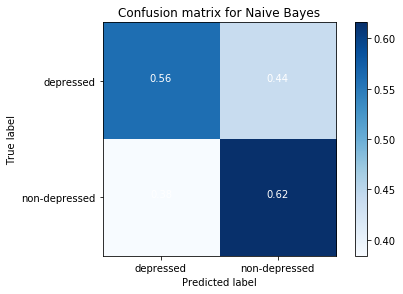

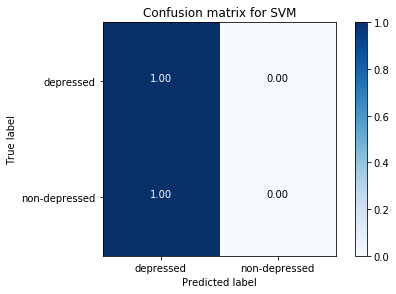

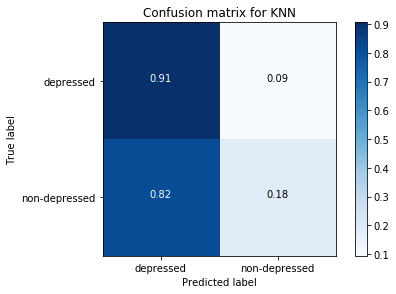

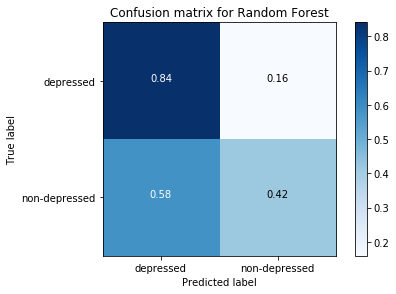

Normalized confusion matrix
[[0.56031128 0.43968872]
 [0.384      0.616     ]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]
Normalized confusion matrix
[[0.90661479 0.09338521]
 [0.816      0.184     ]]
Normalized confusion matrix
[[0.84046693 0.15953307]
 [0.584      0.416     ]]


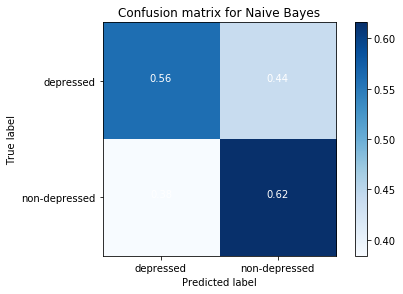

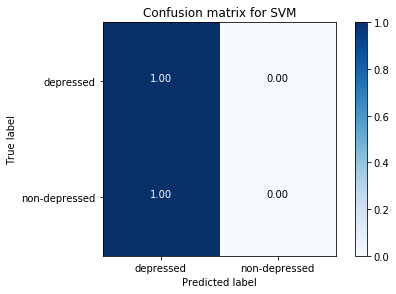

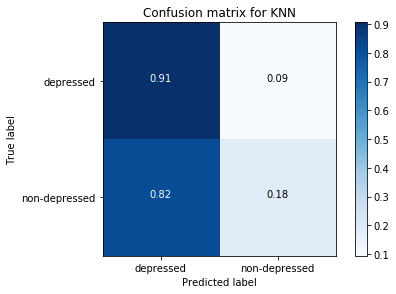

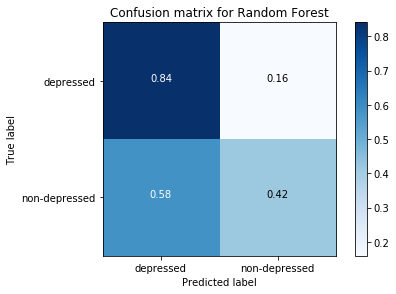

In [71]:
for index in range(len(classifiers)):
    plt.figure()
    plot_confusion_matrix(classifiers[index], class_names, True, 'Confusion matrix for ' + classifier_names[index])
    index+=1

plt.show()
class_names = ['depressed', 'non-depressed']
classifiers = [cm_NB, cm_SVM, cm_KNN, cm_RF]
classifier_names = ['Naive Bayes', 'SVM', 'KNN', 'Random Forest']
index = 0
for index in range(len(classifiers)):
    plt.figure()
    plot_confusion_matrix(classifiers[index], class_names, True, 'Confusion matrix for ' + classifier_names[index])
    index+=1

plt.show()

## Part One Features

## Feature Analysis based on metadata and tweets

In [7]:
columns = ['user', 'depression', 'absolutist_terms', 'tsugawa_terms', 'avg_sentiment', 'first_person','avg_word_length','avg_char_length', 'insomnia_index', 'retweet_rate', 'url_percent', 'avg_usertags', 'avg_unique_usertags']
train_data=pd.DataFrame(columns=columns)
test_data=pd.DataFrame(columns=columns)

#read user tweets
for user, condition in user_condition.items():
    test = False
    tweet_train_file = train_dir + user + '.tweets'
    tweet_test_file = test_dir + user + '.tweets'
    if os.path.isfile(tweet_train_file):
        tweet_file = tweet_train_file 
    elif os.path.isfile(tweet_test_file):
        tweet_file = tweet_test_file
        test = True
    else:
        print('no tweets found for user')
        continue
    
    try:  
        print('Reading file '+ tweet_file)
        tweets = pd.read_json(tweet_file, lines=True)
        tweets['user'] = user
        tweets['depression'] = condition
        # get list of tweets for each user
        tweet_texts = []
        insomnia_pos_count = 0
        insomnia_neg_count = 0
        num_retweets = 0
        num_urls = 0
        num_usertags = 0
        set_usertags = set()
        for i in range(len(tweets)):
            tweet = tweets.iloc[i]
            # preprocess tweet texts per user 
            processed_tweet = preprocess_tweet(tweet['text'])
            tweet_texts.append(processed_tweet)
            num_retweets = retweet_count(tweet, num_retweets)
            num_urls = url_count(tweet, num_urls)
            num_usertags, set_usertags = usertags(tweet, num_usertags, set_usertags)
            insomnia_pos_count, insomnia_neg_count = insomnia_count(tweet, insomnia_pos_count, insomnia_neg_count)
            
        tweets['insomnia_index'] = (insomnia_neg_count - insomnia_pos_count) / len(tweets)
        tweets['retweet_rate'] = num_retweets / len(tweets)
        tweets['url_percent'] = num_urls / len(tweets)
        tweets['avg_usertags'] = num_usertags / len(tweets)
        tweets['avg_unique_usertags'] = len(set_usertags) / len(tweets)
        tweets['first_person'] = first_person(tweet_texts)
        tweets['avg_sentiment'] = avg_sentiment(tweet_texts)
        tweets['tsugawa_terms'] = tsugawa_terms(tweet_texts)
        tweets['absolutist_terms'] = absolutist_terms(tweet_texts)
        word_char_lengths = num_word_char(tweet_texts)
        tweets['avg_word_length'] = word_char_lengths[0]
        tweets['avg_char_length'] = word_char_lengths[1]
        
        user_row = tweets[columns].loc[0:0]
        if test == True:
            test_data = test_data.append(user_row)
        else:
            train_data = train_data.append(user_row)
    except:
        print("Error parsing tweet!")

no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_training_data/p1oWIeRy95.tweets
Reading file final_training_data/u6Q1cPYaegBS.tweets
Reading file final_training_data/q5nbV1Dwkx3Uz8y.tweets
Error parsing tweet!
Reading file final_training_data/cpZb1zL.tweets
Reading file final_training_data/nC8trwq.tweet

Reading file final_training_data/fS_NsCmikG.tweets
Reading file final_training_data/r_AL08Us8KD.tweets
Reading file final_training_data/epbVjo65LYSb.tweets
Reading file final_training_data/fjLCf4wIe1Yts.tweets
Reading file final_training_data/hMuEjR7TAHw.tweets
Reading file final_training_data/l02NBMxaBtp.tweets
Reading file final_training_data/xR7COyw1hCgMdJ.tweets
Reading file final_training_data/fPnJmwvigb4NDB.tweets
Error parsing tweet!
Reading file final_training_data/c6RBMyzEGz.tweets
Reading file final_training_data/lNkP1wbG_.tweets
Reading file final_training_data/tYbkBjKn_HhbKA.tweets
Reading file final_training_data/tFm_Zt17.tweets
Reading file final_training_data/hWx1ZCISapk.tweets
Reading file final_training_data/f1gToeZMsown.tweets
Reading file final_training_data/lvXWGVOeVbaO.tweets
Error parsing tweet!
Reading file final_training_data/ndt26Jc2.tweets
Reading file final_training_data/tjUQM0XFoFd6.tweets
Reading file final_training_data/pKiT8RjFUoFNN.tweets
Reading file fi

Reading file final_training_data/d5W9F315ClWuT.tweets
Reading file final_training_data/xbm01RF4kr.tweets
Reading file final_training_data/u9k5tz3yeg38Z.tweets
Reading file final_training_data/quD3WcPmeNf9Ver.tweets
Reading file final_training_data/b7JDj_Sb.tweets
Reading file final_training_data/mrBNd41K.tweets
Reading file final_training_data/mFt6W0RyBGub.tweets
Reading file final_training_data/q0W_J_Ee.tweets
Reading file final_training_data/fPh49Tvz_Cu0y0R.tweets
Reading file final_training_data/vmXfij.tweets
Reading file final_training_data/pFRUDVnfMvng.tweets
Reading file final_training_data/ijinLoqohOP.tweets
Error parsing tweet!
Reading file final_training_data/oFnukUt21FYo.tweets
Reading file final_training_data/w9rpyg0EUSU03g.tweets
Reading file final_training_data/no6eldDW_U0Pq_.tweets
Reading file final_training_data/zvnSahMKTd.tweets
Reading file final_training_data/eTB92A2U3X5.tweets
Reading file final_training_data/wi3bUI3nYk_Pd.tweets
Reading file final_training_data/wWd

Reading file final_training_data/fdvbKeh4NIZ.tweets
Reading file final_training_data/hANUdm_kJzGbnl.tweets
Reading file final_training_data/uiHBxWiuleJL.tweets
Reading file final_training_data/bBj3tEy.tweets
Reading file final_training_data/sY0azlpwRe.tweets
Reading file final_training_data/xosKMdKMJ.tweets
Reading file final_training_data/cmvxX_NWJd5DL.tweets
Reading file final_training_data/gAxzxIWjvahh.tweets
Reading file final_training_data/xnozWTA40p.tweets
Reading file final_training_data/fvFcDA0P8oJ_6.tweets
Reading file final_training_data/dJJPhbPju.tweets
Reading file final_training_data/p2HB96F23s.tweets
Error parsing tweet!
Reading file final_training_data/rPubIuIf.tweets
Reading file final_training_data/guU7PUipk5n4.tweets
Reading file final_training_data/f2fooSn.tweets
Reading file final_training_data/cS8tppTDL3.tweets
Reading file final_training_data/bi0xOvA88H1OT.tweets
Error parsing tweet!
Reading file final_training_data/j11yDOcjhW.tweets
Reading file final_training_da

Reading file final_training_data/tkkzidBh9ZWsG.tweets
Error parsing tweet!
Reading file final_training_data/u4Nz74q5SCdyObn.tweets
Reading file final_training_data/k6aDpyIS0.tweets
Reading file final_training_data/t91wktiYrsF.tweets
Reading file final_training_data/e3OjnFN0VbsoV.tweets
Reading file final_training_data/ms_0SI9_YGA2B.tweets
Reading file final_training_data/qodUBoXFyHq6T03.tweets
Error parsing tweet!
Reading file final_training_data/snMj6XzZvN.tweets
Reading file final_training_data/k7F4IlnB5.tweets
Reading file final_training_data/oxkZfV_7pE.tweets
Reading file final_training_data/oetczv3_S3oPac.tweets
Error parsing tweet!
Reading file final_training_data/dadlS4XUHbvfHi.tweets
Error parsing tweet!
Reading file final_training_data/fNlTErjbA.tweets
Reading file final_training_data/ukNquMkP3W1.tweets
Reading file final_training_data/L844xvCOIjDJ3ot.tweets
Reading file final_training_data/n4BOlCvNErp75.tweets
Reading file final_training_data/dVulYpSpRz.tweets
Reading file fi

Reading file final_training_data/f8D2Tt5ySDU.tweets
Reading file final_training_data/pYZlibq.tweets
Reading file final_training_data/iTe8_RfG8.tweets
Reading file final_training_data/gxssg5e.tweets
Reading file final_training_data/b90Xd3CWW.tweets
Reading file final_training_data/c5egAWoKy8.tweets
Reading file final_training_data/jGC0j9ijNBn1.tweets
Reading file final_training_data/fONxVasny2.tweets
Reading file final_training_data/wmwQ6RjBaiq.tweets
Reading file final_training_data/nVHGUx.tweets
Reading file final_training_data/sObIxboD1JgpBHe.tweets
Reading file final_training_data/n8bDYXAG5S85.tweets
Reading file final_training_data/vpcHddZiD.tweets
Reading file final_training_data/mOanz1kg6b0oSxG.tweets
Reading file final_training_data/QIbT5IkcWpj.tweets
Reading file final_training_data/c1IQ5GCb_99LSxX.tweets
Error parsing tweet!
Reading file final_training_data/id4O8tg.tweets
Reading file final_training_data/sZVVktDN8qqjA.tweets
Reading file final_training_data/hbwm5Tyt801.tweets


no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/sgh85pBVTrOI5.tweets
Error parsing tweet!
Reading file final_testing_data/j15O_iq22wviI.tweets
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/LSdFmgw.tweets
Reading file final_testing_data/OHrn8EBpdMbPc.tweets
Error parsing tweet!
Reading file final_testing_data/oJBU65HkIKJ.tweets
Error parsing tweet!
Reading file final_testing_data/qUi02Rtnn9.tweets
Reading file final_testing_data/qz15FDkWR.tweets
Reading file final_testing_data/qdUlpt7G_xuDJ.tweets
Reading file final_testing_data/5trLyO.tweets
Reading file final_testing_data/xamatEwJzmBM.tweets
Reading file final_testing_data/dztLiT.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/pjmeJFCj9.tweets
Reading file final_testing_data/pLwkcIQ1KPKKNLE.tweets
Error parsing tweet!
Reading f

Reading file final_testing_data/vw1G3Kfi1K.tweets
Reading file final_testing_data/ede9eCGcC.tweets
Reading file final_testing_data/ngEVlO5dC.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/uAYNfjer5H4.tweets
Error parsing tweet!
Reading file final_testing_data/ohKTsoykPhh8ZuS.tweets
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/hOnaPe9X9ZuuoN.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/cJJldnDL5oP_QD.tweets
Error parsing tweet!
Reading file final_testing_data/dl7Vaigu.tweets
Reading file final_testing_data/ubNzj1B.tweets
Error parsing tweet!
Reading file final_testing_data/ngl7M2ou5B.tweets
Reading file final_testing_data/uwcXjnBq.tweets
Reading file final_testing_data/sopdPKAFkw3QerH.tweets
Reading file final_testing_data/u_P3xdlRS8naqbi.tweets
Reading file final_tes

no tweets found for user
no tweets found for user
Reading file final_testing_data/lYU6yETIaN3H.tweets
Reading file final_testing_data/cEkZxh6OEtC2.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/nYpuu7dWvXMFUG9.tweets
Reading file final_testing_data/rSaU1hkUY.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/puTtjUFpRciDHX.tweets
Reading file final_testing_data/gGRekzUp_6oLZ2P.tweets
Reading file final_testing_data/ljsDD9z1vYpW.tweets
no tweets found for user
Reading file final_testing_data/dn8Oyr4n.tweets
Reading file final_testing_data/vcR68dcu1de.tweets
Reading file final_testing_data/h8z2xMU8q7mMWY.tweets
Reading file final_testing_data/v8tLj9e.tweets
Reading file final_testing_data/q5tE5dA6xiDnQ.tweets
Error parsing tweet!
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/wo5BVq1NFaqo08.tweets
Reading file final_testing_data/p43muIH.tweets
Readin

Reading file final_testing_data/uF76QlQxlcOYn.tweets
Reading file final_testing_data/d8sMxxX8uhYioVo.tweets
Reading file final_testing_data/vvyhD9dsqxT.tweets
Reading file final_testing_data/bjc2Kgay.tweets
Reading file final_testing_data/f2gRmoHUul.tweets
Reading file final_testing_data/le__3ezwpf.tweets
Reading file final_testing_data/fyl6PKTMEeaweMw.tweets
Error parsing tweet!
Reading file final_testing_data/jKXYTGn9CNGOtK.tweets
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/ll_gyBvD2vo9A.tweets
Reading file final_testing_data/eVVQgZHpk9.tweets
Reading file final_testing_data/xMZSqgcL0pH.tweets
Error parsing tweet!
Reading file final_testing_data/si_wpIUDCDtRMtp.tweets
Reading file final_testing_data/iuqR1sQB9srL.tweets
no tweets found for user
Reading file final_testing_data/lCwkSx2Fau.tweets
Reading file final_testing_data/sqOFbJ0CQYM.tweets
Reading file final_testing_data/wuwHUfST.tweets
no twee

In [8]:
# save user data and features to file
test_data.to_csv('test_new.csv', encoding='utf-8')
train_data.to_csv('train_new.csv', encoding='utf-8')

In [9]:
# read user data from file
test_data = pd.read_csv('test_new.csv')
train_data = pd.read_csv('train_new.csv')

In [10]:
train_data

,Unnamed: 0,user,depression,absolutist_terms,tsugawa_terms,avg_sentiment,first_person,avg_word_length,avg_char_length,insomnia_index,retweet_rate,url_percent,avg_usertags,avg_unique_usertags
0,0,p1oWIeRy95,1,0.407333,0.023667,0.354151,0.075667,6.507333,43.698333,-0.213333,531.117000,0.074000,0.669667,0.099667
1,0,u6Q1cPYaegBS,0,0.282152,0.060367,0.114795,0.068241,7.842520,51.421260,0.622047,127.213911,0.018373,0.791339,0.124672
2,0,cpZb1zL,0,0.310513,0.110024,0.078047,0.080685,8.418093,58.454768,-0.056235,112.332518,0.405868,0.584352,0.305623
3,0,nC8trwq,1,0.277333,0.106667,0.080455,0.175000,6.342000,41.750667,0.056667,468.096333,0.007333,0.776667,0.118000
4,0,mbKpnEfzJFe,0,0.332667,0.087000,0.098610,0.113333,6.004333,41.165333,-0.398000,147.364333,0.021667,0.576667,0.117667
5,0,cMwx3Gi9RuskPTa,0,0.274802,0.077783,0.076941,0.146251,6.768048,46.573824,0.419655,21.761993,0.018165,0.763857,0.238007
6,0,gnau5VYmZon,1,0.188667,0.051333,0.172316,0.051667,7.946000,59.646000,-0.018000,10.998333,0.259333,0.848000,0.297333
7,0,w5zZbsisYcaA,0,0.055556,0.011530,0.190582,0.008386,8.642558,71.154088,0.482180,24.219078,0.766247,0.230608,0.174004
8,0,q69HY7gQXtabz,0,0.225667,0.045667,0.136086,0.065667,9.527667,73.880333,-0.087333,5.197333,0.425333,1.164333,0.383667
9,0,ee7ABQXno,0,0.172667,0.056333,0.181194,0.111000,5.629333,37.735000,0.069333,28.748667,0.064667,0.801000,0.090333


## Create Feature Matrix

In [11]:
import numpy as np

def create_feature_matrix(data):
    feature_matrix = []
    for i in range(len(data)):
        user_features = np.array(data.iloc[i,2:10], dtype = np.float32)
        feature_matrix.append(user_features)
    return feature_matrix

train_feature_matrix = np.array(create_feature_matrix(train_data))
test_feature_matrix = np.array(create_feature_matrix(test_data))

print(len(train_feature_matrix))
print(len(test_feature_matrix))

794
395


In [12]:
# get train, test data 
X_train = train_feature_matrix[:,1:]
y_train = train_feature_matrix[:,0]
X_test = test_feature_matrix[:,1:]
y_test = test_feature_matrix[:,0]

## Train Models

In [13]:
# apply naive bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import itertools

clf = GaussianNB()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
pred = clf.predict(X_test)

# Compute confusion matrix
cm_NB = confusion_matrix(y_test, pred)
print(score, cm_NB)

0.7037974683544304 [[219  50]
 [ 67  59]]


In [14]:
# apply SVM model
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
pred = clf.predict(X_test)

# Compute confusion matrix
cm_SVM = confusion_matrix(y_test, pred)
print(score, cm_SVM)

0.6835443037974683 [[269   0]
 [125   1]]


In [22]:
# apply KNN model
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=19)
neigh.fit(X_train, y_train)
score = neigh.score(X_test, y_test)
pred = neigh.predict(X_test)

# Compute confusion matrix
cm_KNN = confusion_matrix(y_test, pred)
print(score, cm_KNN)

0.6759493670886076 [[249  20]
 [108  18]]


In [24]:
# apply random forest model
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=13)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
pred = clf.predict(X_test)

# Compute confusion matrix
cm_RF = confusion_matrix(y_test, pred)
print(score, cm_RF)

0.7291139240506329 [[230  39]
 [ 68  58]]


In [28]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=14)
gbc.fit(X_train, y_train)
score = gbc.score(X_test, y_test)
pred = gbc.predict(X_test)

# Compute confusion matrix
cm_GBC = confusion_matrix(y_test, pred)
print(score, cm_GBC)

0.7088607594936709 [[247  22]
 [ 93  33]]


In [30]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         n_estimators=20)

bdt.fit(X_train, y_train)
score = bdt.score(X_test, y_test)
pred = bdt.predict(X_test)

# Compute confusion matrix
cm_BDT = confusion_matrix(y_test, pred)
print(score, cm_BDT)

0.660759493670886 [[218  51]
 [ 83  43]]


In [31]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class EnsembleClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):
        for clf in self.clfs:
            clf.fit(X, y)

    def predict(self, X):
        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        if self.weights:
            avg = self.predict_proba(X)

            maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)

        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])

        return maj

    def predict_proba(self, X):
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        avg = np.average(self.probas_, axis=0, weights=self.weights)

        return avg


In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
score = lr.score(X_test, y_test)
print(score)

0.6962025316455697


In [34]:
clf1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         n_estimators=100)
clf2 = GaussianNB()
clf3 = svm.SVC()
clf4 = LogisticRegression()
clf5 = KNeighborsClassifier(n_neighbors=12)
clf6 = RandomForestClassifier(n_estimators=12)


eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3, clf4, clf5, clf6], weights=[2,1,1,1,1,2])
eclf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

0.7291139240506329


In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.56031128 0.43968872]
 [0.384      0.616     ]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]
Normalized confusion matrix
[[0.90661479 0.09338521]
 [0.816      0.184     ]]
Normalized confusion matrix
[[0.84046693 0.15953307]
 [0.584      0.416     ]]


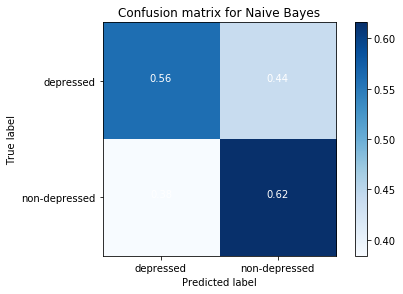

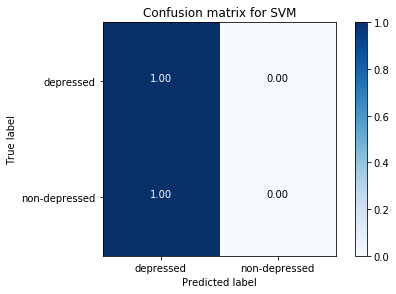

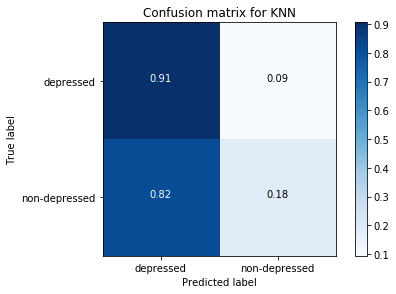

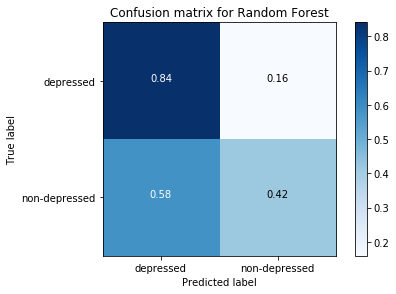

In [69]:
class_names = ['depressed', 'non-depressed']
classifiers = [cm_NB, cm_SVM, cm_KNN, cm_RF]
classifier_names = ['Naive Bayes', 'SVM', 'KNN', 'Random Forest']
index = 0
for index in range(len(classifiers)):
    plt.figure()
    plot_confusion_matrix(classifiers[index], class_names, True, 'Confusion matrix for ' + classifier_names[index])
    index+=1

plt.show()

## KFolds and Cross Validation

In [74]:
# combine train, test data to perform K fold and cross validation
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))


In [23]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
nb = GaussianNB()
svc = svm.SVC()
neigh = KNeighborsClassifier(n_neighbors=12)
rf = RandomForestClassifier(n_estimators=12)
nb_score = 0
svm_score = 0
neigh_score = 0
rf_score = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # compute accuracy for naive bayes 
    nb.fit(X_train, y_train)
    nb_score += nb.score(X_test, y_test)
    
    # compute accuracy for SVM
    svc.fit(X_train, y_train)
    svm_score += svc.score(X_test, y_test)

    # compute accuracy for KNN
    neigh.fit(X_train, y_train)
    neigh_score = neigh.score(X_test, y_test)

    # compute accuracy for random forest
    rf.fit(X_train, y_train)
    rf_score += rf.score(X_test, y_test)

print(nb_score/3, svm_score/3, neigh_score/3, rf_score/3)


NameError: name 'X' is not defined